In [5]:
# ==========================================
# 1. Imports & Paths
# ==========================================

from pathlib import Path
import json
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- Paths ---
NB_DIR = Path.cwd()
DATA_DIR = (NB_DIR / "../data").resolve()
RES_DIR  = (NB_DIR / "../results").resolve()   # use results/ for now
RES_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_CSV = DATA_DIR / "chess_games_clean.csv"

print("Data dir:", DATA_DIR)
print("Results dir:", RES_DIR)
print("Clean dataset:", CLEAN_CSV)

# --- Sklearn / classical ML ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# --- Deep learning (TensorFlow/Keras) ---
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs available:", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(RANDOM_STATE)

# --- Sequence preprocessing ---
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

Data dir: E:\Github Projects\chess-outcome-prediction\data
Results dir: E:\Github Projects\chess-outcome-prediction\results
Clean dataset: E:\Github Projects\chess-outcome-prediction\data\chess_games_clean.csv
TensorFlow version: 2.16.1
Num GPUs available: 0


In [6]:
# ==========================================
# 2. Load Dataset & Train/Val/Test Split
# ==========================================

# Load cleaned dataset
df = pd.read_csv(CLEAN_CSV)
print("Dataset shape:", df.shape)
display(df.head(3))

# Separate target
y = df["target"]

# Drop target + sequence column for numeric features
drop_text = [c for c in ["moves_first15_san"] if c in df.columns]
X_num = df.drop(columns=["target"] + drop_text).select_dtypes(include=[np.number])

print("Numeric features shape:", X_num.shape)

# Encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Save label encoder for later
joblib.dump(le, RES_DIR / "label_encoder.joblib")

# Split into train/val/test (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_num, y_enc, test_size=0.3, stratify=y_enc, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Target classes:", list(le.classes_))

Dataset shape: (142328, 31)


,white_rating,black_rating,rating_diff,avg_rating,white_pawns,black_pawns,white_knights,black_knights,white_bishops,black_bishops,white_rooks,black_rooks,white_queens,black_queens,white_material_value,black_material_value,material_balance_white_minus_black,side_to_move_is_white,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,white_centre_control,black_centre_control,white_mobility_legal_moves,black_mobility_legal_moves,captures_in_first_15_moves,checks_in_first_15_moves,plies_processed,moves_first15_san,target
0,1812,1803,9,1807.5,5,6,2,1,2,2,2,2,1,1,36,34,2,1,0,0,1,0,4,4,48,46,6,0,30,f4 d5 g3 c5 Bg2 Nc6 Nf3 Bf5 O-O e6 d3 g6 Be3 h...,white
1,1840,1791,49,1815.5,6,7,2,1,1,2,2,2,1,1,34,35,-1,1,0,0,0,0,1,3,46,29,5,2,28,e4 b6 d4 Bb7 Bd3 e6 f4 d6 Nf3 h6 O-O a6 Qe2 Ne...,white
2,2193,1782,411,1987.5,8,7,1,1,1,2,2,2,1,1,33,35,-2,1,0,0,0,0,4,3,37,31,4,0,30,d4 Nf6 c4 e6 Nc3 c5 d5 d6 e3 e5 Nf3 Be7 Bd3 Nb...,black


Numeric features shape: (142328, 29)
Train: (99629, 29) Val: (21349, 29) Test: (21350, 29)
Target classes: ['black', 'draw', 'white', nan]


Numeric features: 29
First 10 feature names: ['white_rating', 'black_rating', 'rating_diff', 'avg_rating', 'white_pawns', 'black_pawns', 'white_knights', 'black_knights', 'white_bishops', 'black_bishops']
Train class counts:
black    46060
draw      3860
white    49691
NaN          0
Val class counts:
black     9870
draw       827
white    10648
NaN          0
Test class counts:
black     9871
draw       827
white    10649
NaN          0
Class weights used (by encoded id): {0: 0.5407566217976553, 2: 0.5012426797609225, 1: 12.905310880829015, 3: 1383.736111111111}
OOB score (approx generalisation): 0.6516275381665981
RF — Train Acc: 0.8955 | Train F1(macro): 0.9055
RF — Val   Acc: 0.6571   | Val   F1(macro): 0.3506
RF — Test  Acc: 0.6446  | Test  F1(macro): 0.3487
Saved report → E:\Github Projects\chess-outcome-prediction\results\rf_report.json


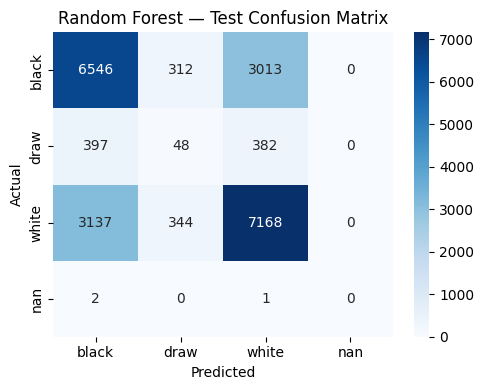

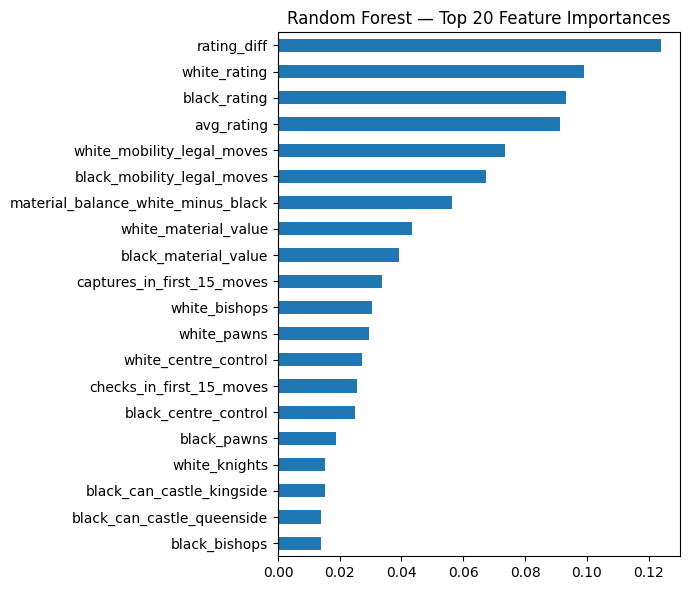

In [7]:
# ==========================================
# 3. Baseline: Random Forest (classical) — tuned
# ==========================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json, os
import numpy as np
import pandas as pd

# ---- Inspect training data / feature space ----
print("Numeric features:", X_train.shape[1])
print("First 10 feature names:", list(X_train.columns[:10]))

def show_distribution(y_enc, name):
    inv = le.inverse_transform(y_enc)
    vc = pd.Series(inv).value_counts().reindex(le.classes_, fill_value=0)
    print(f"{name} class counts:")
    print(vc.to_string())

show_distribution(y_train, "Train")
show_distribution(y_val,   "Val")
show_distribution(y_test,  "Test")

# ---- Class weights (balanced + slight draw boost) ----
# base weights = inverse freq; then upweight 'draw' by x2 to help recall
counts = Counter(y_train)
n_samples = sum(counts.values())
n_classes = len(le.classes_)
base_w = {cls: n_samples / (n_classes * cnt) for cls, cnt in counts.items()}

# find encoded id for "draw" (if present)
draw_id = None
for idx, name in enumerate(le.classes_):
    if name.lower() == "draw":
        draw_id = idx
        break
if draw_id is not None:
    base_w[draw_id] = base_w[draw_id] * 2.0  # boost draws
print("Class weights used (by encoded id):", base_w)

# ---- Model (slightly regularised to reduce overfitting) ----
rf = RandomForestClassifier(
    n_estimators=400,          # a bit smaller for speed/size, still strong
    max_depth=24,             # limit depth to curb overfit
    max_features="sqrt",      # common good default
    min_samples_split=6,
    min_samples_leaf=3,
    class_weight=base_w,      # our custom weights with draw boost
    bootstrap=True,
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf.fit(X_train, y_train)
print("OOB score (approx generalisation):", getattr(rf, "oob_score_", None))

# ---- Eval helper ----
def eval_rf(model, Xtr, ytr, Xva, yva, Xte, yte, class_names):
    preds_tr = model.predict(Xtr)
    preds_va = model.predict(Xva)
    preds_te = model.predict(Xte)

    out = {
        "train": {"acc": accuracy_score(ytr, preds_tr),
                  "f1_macro": f1_score(ytr, preds_tr, average="macro")},
        "val":   {"acc": accuracy_score(yva, preds_va),
                  "f1_macro": f1_score(yva, preds_va, average="macro")},
        "test":  {"acc": accuracy_score(yte, preds_te),
                  "f1_macro": f1_score(yte, preds_te, average="macro"),
                  "report": classification_report(yte, preds_te, target_names=class_names, output_dict=True),
                  "confusion_matrix": confusion_matrix(yte, preds_te).tolist()},
    }
    return out

rf_report = eval_rf(rf, X_train, y_train, X_val, y_val, X_test, y_test, list(le.classes_))
print(f"RF — Train Acc: {rf_report['train']['acc']:.4f} | Train F1(macro): {rf_report['train']['f1_macro']:.4f}")
print(f"RF — Val   Acc: {rf_report['val']['acc']:.4f}   | Val   F1(macro): {rf_report['val']['f1_macro']:.4f}")
print(f"RF — Test  Acc: {rf_report['test']['acc']:.4f}  | Test  F1(macro): {rf_report['test']['f1_macro']:.4f}")

# ---- Save report only (keep repo light) ----
with open(RES_DIR / "rf_report.json", "w", encoding="utf-8") as f:
    json.dump(rf_report, f, indent=2)
print("Saved report →", RES_DIR / "rf_report.json")

# ---- Confusion matrix (test) ----
cm = np.array(rf_report["test"]["confusion_matrix"])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Random Forest — Test Confusion Matrix")
plt.tight_layout()
plt.savefig(RES_DIR / "rf_confusion_matrix.png", dpi=150)
plt.show()

# ---- Feature importances (top 20) ----
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(7, 6))
importances[::-1].plot(kind="barh")
plt.title("Random Forest — Top 20 Feature Importances")
plt.tight_layout()
plt.savefig(RES_DIR / "rf_feature_importances_top20.png", dpi=150)
plt.show()

Vocab size (incl PAD/OOV): 3239
Seq shapes — train/val/test: (99629, 30) (21349, 30) (21350, 30)
Seq model class weights: {0: 0.5407566217976553, 2: 0.5012426797609225, 1: 12.905310880829015, 3: 1383.736111111111}
Epoch 1/40
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0616 - loss: 1.6457 - val_accuracy: 0.0448 - val_loss: 1.5211
Epoch 2/40
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0925 - loss: 1.4408 - val_accuracy: 0.0719 - val_loss: 1.4670
Epoch 3/40
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1188 - loss: 1.2653 - val_accuracy: 0.1011 - val_loss: 1.3804
Epoch 4/40
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1412 - loss: 1.0952 - val_accuracy: 0.1372 - val_loss: 1.3253
Epoch 5/40
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1669 - loss: 1.0145 - val_accuracy: 0.1731 - val_loss: 1.2779
Epoch 6/40
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1988 - loss: 0.9770 - val_accuracy: 0.2607 - val_loss: 1.1806
Epoch 7/40
195/195

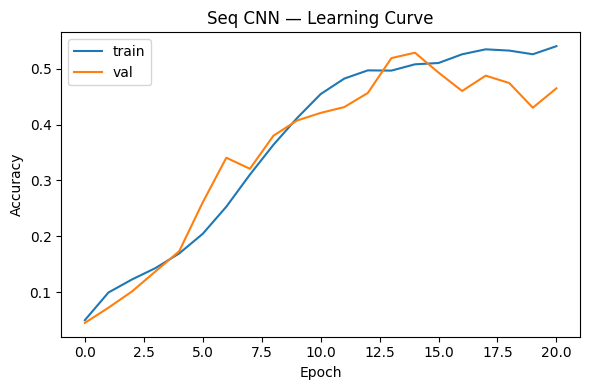

Seq CNN — Val Acc: 0.5288 | Val F1(macro): 0.2845
Seq CNN — Test Acc: 0.5226 | Test F1(macro): 0.2801
Saved: E:\Github Projects\chess-outcome-prediction\results\seq_report.json and E:\Github Projects\chess-outcome-prediction\results\seq_tokenizer.json


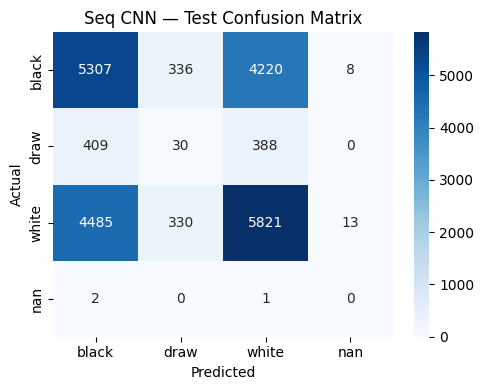

In [8]:
# ==========================================
# 4. Deep Learning on move sequences (first 15 moves)
# ==========================================

import re, json, os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Sanity: make sure the sequence column exists
assert "moves_first15_san" in df.columns, "moves_first15_san not found in the dataset."

# --- Use the SAME indices as our numeric split to avoid leakage
train_idx = X_train.index
val_idx   = X_val.index
test_idx  = X_test.index

seq_all = df["moves_first15_san"].fillna("")

seq_train = seq_all.loc[train_idx].tolist()
seq_val   = seq_all.loc[val_idx].tolist()
seq_test  = seq_all.loc[test_idx].tolist()

# --- Tokeniser (simple SAN whitespace split; strip move numbers just in case)
num_re = re.compile(r"^\d+\.{1,3}$")  # tokens like 1., 1..., etc.

def to_tokens(s: str):
    toks = []
    for t in s.strip().split():
        if not t or num_re.match(t):
            continue
        toks.append(t)
    return toks

tok_train = [to_tokens(s) for s in seq_train]
tok_val   = [to_tokens(s) for s in seq_val]
tok_test  = [to_tokens(s) for s in seq_test]

# --- Build vocab from TRAIN ONLY (no leakage)
PAD, OOV = "<PAD>", "<OOV>"
counter = Counter(t for seq in tok_train for t in seq)
itos = [PAD, OOV] + sorted(counter.keys())                 # index→token
stoi = {t:i for i,t in enumerate(itos)}                    # token→index
vocab_size = len(itos)
print("Vocab size (incl PAD/OOV):", vocab_size)

# --- Encode + pad (fixed 30 tokens = 15 moves)
MAXLEN = 30

def encode_pad(token_seqs, stoi, maxlen=MAXLEN):
    arr = np.zeros((len(token_seqs), maxlen), dtype=np.int32)
    for i, seq in enumerate(token_seqs):
        ids = [stoi.get(t, 1) for t in seq]  # 1 = OOV
        ids = ids[:maxlen]
        arr[i, :len(ids)] = ids
    return arr

Xtr_seq = encode_pad(tok_train, stoi, MAXLEN)
Xva_seq = encode_pad(tok_val,   stoi, MAXLEN)
Xte_seq = encode_pad(tok_test,  stoi, MAXLEN)

print("Seq shapes — train/val/test:", Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape)

# --- Class weights (same idea as RF; boost draws a bit)
from collections import Counter
counts = Counter(y_train)
n_samples = sum(counts.values())
n_classes = len(le.classes_)
class_w = {cls: n_samples / (n_classes * cnt) for cls, cnt in counts.items()}

draw_id = None
for idx, name in enumerate(le.classes_):
    if name.lower() == "draw":
        draw_id = idx
        break
if draw_id is not None:
    class_w[draw_id] = class_w[draw_id] * 2.0
print("Seq model class weights:", class_w)

# --- Build the model (Embedding → 1D-CNN → GlobalMaxPool → Dense)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(RANDOM_STATE)

num_classes = len(le.classes_)

model = keras.Sequential([
    layers.Input(shape=(MAXLEN,)),
    layers.Embedding(input_dim=vocab_size, output_dim=64, mask_zero=False),
    layers.Conv1D(128, kernel_size=3, padding="same", activation="relu"),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

cb_early = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=6, restore_best_weights=True
)

hist = model.fit(
    Xtr_seq, y_train,
    validation_data=(Xva_seq, y_val),
    epochs=40,
    batch_size=512,
    callbacks=[cb_early],
    class_weight=class_w,
    verbose=1,
)

# --- Learning curve
plt.figure(figsize=(6,4))
plt.plot(hist.history["accuracy"], label="train")
plt.plot(hist.history["val_accuracy"], label="val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Seq CNN — Learning Curve")
plt.legend()
plt.tight_layout()
plt.savefig(RES_DIR / "seq_learning_curve.png", dpi=150)
plt.show()

# --- Evaluate helper
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def eval_seq(model, Xs, Ys):
    probs = model.predict(Xs, verbose=0)
    preds = probs.argmax(axis=1)
    return {
        "acc": accuracy_score(Ys, preds),
        "f1_macro": f1_score(Ys, preds, average="macro"),
        "report": classification_report(Ys, preds, target_names=list(le.classes_), output_dict=True),
        "confusion_matrix": confusion_matrix(Ys, preds).tolist(),
    }

rep_train = eval_seq(model, Xtr_seq, y_train)
rep_val   = eval_seq(model, Xva_seq, y_val)
rep_test  = eval_seq(model, Xte_seq, y_test)

seq_report = {"train": rep_train, "val": rep_val, "test": rep_test}
print(f"Seq CNN — Val Acc: {rep_val['acc']:.4f} | Val F1(macro): {rep_val['f1_macro']:.4f}")
print(f"Seq CNN — Test Acc: {rep_test['acc']:.4f} | Test F1(macro): {rep_test['f1_macro']:.4f}")

# --- Save light artefacts (report + tokenizer)
with open(RES_DIR / "seq_report.json", "w", encoding="utf-8") as f:
    json.dump(seq_report, f, indent=2)
with open(RES_DIR / "seq_tokenizer.json", "w", encoding="utf-8") as f:
    json.dump({"itos": itos, "MAXLEN": MAXLEN}, f)

print("Saved:", RES_DIR / "seq_report.json", "and", RES_DIR / "seq_tokenizer.json")

# --- Confusion matrix (test)
cm = np.array(seq_report["test"]["confusion_matrix"])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Seq CNN — Test Confusion Matrix")
plt.tight_layout()
plt.savefig(RES_DIR / "seq_confusion_matrix.png", dpi=150)
plt.show()

# (Optional) If you ever want to save the model (kept off by default to keep repo light)
# model.save(RES_DIR / "seq_cnn_model.keras")